### Import Data and Dependencies


In [1]:
import pandas as pd
import nltk
import numpy as np
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords            #to filterout useless data
stopword = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer      #to link words with similar meanings to one word.
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfTransformer
hsd =  pd.read_parquet('/Users/preethamroy/Desktop/SEC/HSD/0000.parquet')


### Label Data depending on Class

In [2]:
hsd['label'] = hsd['class'].map({0:'Hate Speech',1:'Offensive Language',2:'No Hate and Offensive'})

### Clean and Preprocess the Data

In [3]:

def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub(r"\@w+|\#",'',text)
    text = re.sub(r"[^\w\s]",'',text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    tweet_tokens = word_tokenize(text)
    filtered_tweets=[w for w in tweet_tokens if not w in stopword] #removing stopwords
    return " ".join(filtered_tweets)

hsd.tweet = hsd['tweet'].apply(clean)

### Remove Duplicates
tweetData = hsd[['tweet','label']].drop_duplicates('tweet')

### Lemmatizer
Lemmatizer =  WordNetLemmatizer()
def lemmatizing(text):
    tweet = [Lemmatizer.lemmatize(word) for word in text.split()]
    return ' '.join(tweet)

tweetData.tweet  = tweetData['tweet'].apply(lemmatizing)

### Stats

tweetData['label'].value_counts() # to see distribution of labels


label
Offensive Language       18984
No Hate and Offensive     4113
Hate Speech               1409
Name: count, dtype: int64

### Visualizing Non-Hate Tweets

                                                tweet                  label
0   rt mayasolovely woman shouldnt complain cleani...  No Hate and Offensive
40               momma said pussy cat inside doghouse  No Hate and Offensive
63      simplyaddictedtoguys woof woof hot scally lad  No Hate and Offensive
66                  allaboutmanfeet woof woof hot sol  No Hate and Offensive
67   allyhaaaaa lemmie eat oreo amp dish one oreo lol  No Hate and Offensive


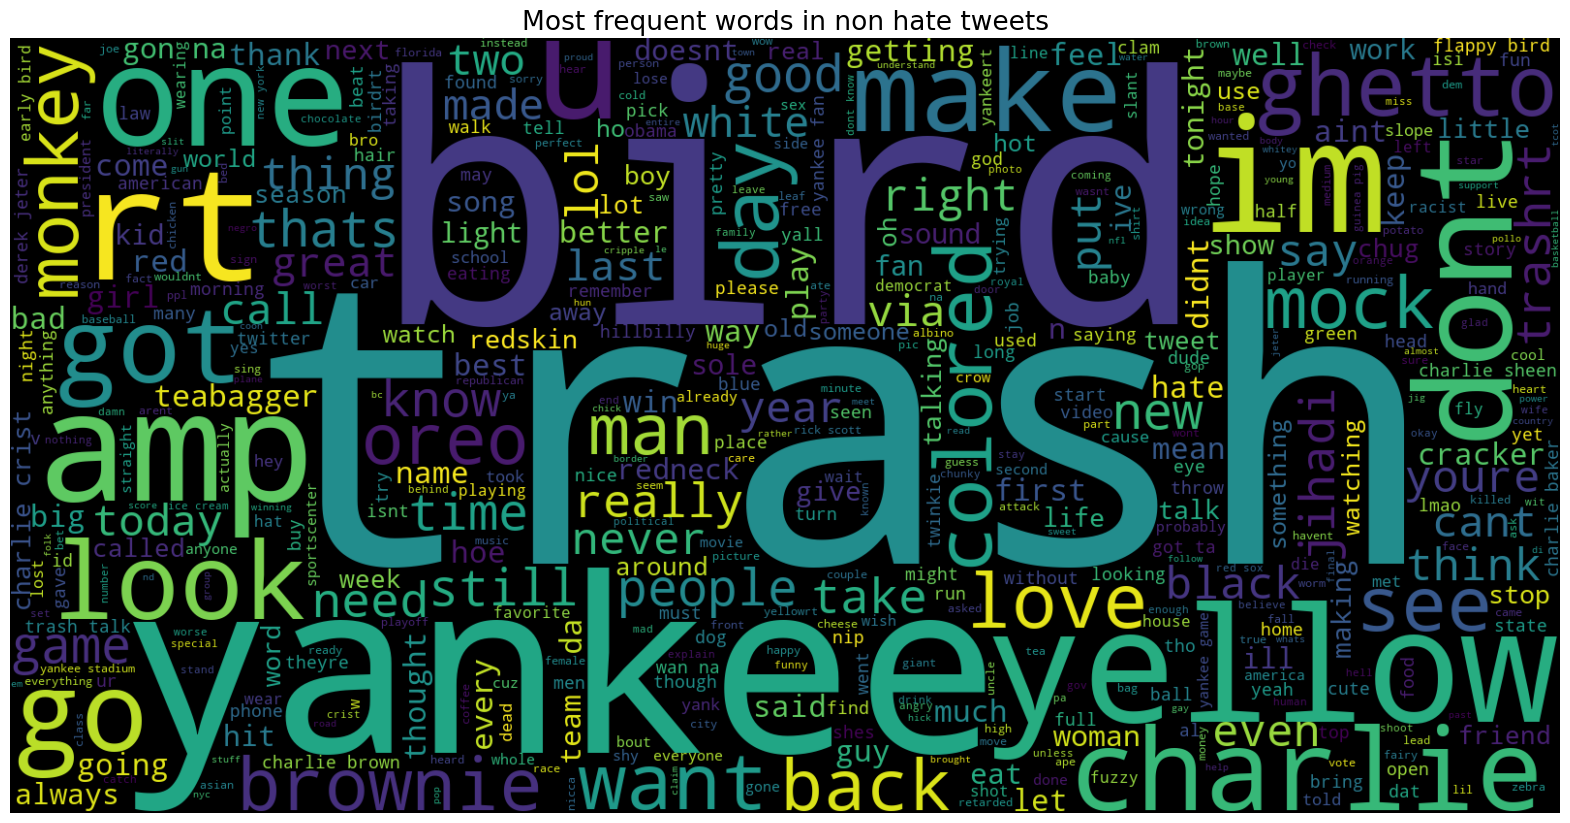

In [4]:
# visualizing non-hate tweets
non_hate_tweets = tweetData[tweetData.label=='No Hate and Offensive']
print(non_hate_tweets.head())

# visualizing non-hate tweets using word cloud
text=''.join([word for word in non_hate_tweets['tweet']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud=WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most frequent words in non hate tweets", fontsize=19)
plt.show()

### Encoding and Splitting data

In [5]:
### Bag of Words Algorithm
from sklearn.feature_extraction.text import TfidfVectorizer
vect=TfidfVectorizer(ngram_range=(1,3)).fit(tweetData['tweet'])
feature_names=vect.get_feature_names_out()

### Transforming the data into vectors
X = tweetData.tweet
Y = tweetData.label
X = vect.transform(X)

### Splitting the data into training and testing data

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


### printing the size of training and testing data
print("Size of X_train", (X_train.shape))
print("Size of Y_train", (Y_train.shape))
print("Size of X_test", (X_test.shape))
print("Size of Y_test", (Y_test.shape))

Size of X_train (19604, 303251)
Size of Y_train (19604,)
Size of X_test (4902, 303251)
Size of Y_test (4902,)


### Model Training and Testing

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
#for training the data on logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, Y_train) #loading x_train and y_train data on model
logreg_predict = logreg.predict(X_test) #predicting the value for test data
logreg_acc = accuracy_score(logreg_predict, Y_test)

print("Test accuracy: {:.2f}%".format(logreg_acc*100)) #printing accuracy of the model


### Here Y_train contains values of 3 classes
# since logistic regression is binary classifier we need to convert it into 3binary classifiers
# scikit learn provides a function for this automatically
# Internally this is what it does
# For each class
# for class in classes:
#     # Construct a new y where 1 is the current class and 0 is all other classes
#     y_new = [1 if y == class else 0 for y in Y_train]
    
#     # Train the logistic regression model on the new y
#     logreg.fit(X_train, y_new)


Test accuracy: 86.21%


### Save Model and Vectorizer

In [9]:
import pickle
pickle.dump(logreg, open('trained_HSD.sav', 'wb'))
pickle.dump(vect.vocabulary_, open('vectorizer_HSD.pkl', 'wb'))

[[  14   10  259]
 [   0  447  361]
 [   3   43 3765]]


                       precision    recall  f1-score   support

          Hate Speech       0.82      0.05      0.09       283
No Hate and Offensive       0.89      0.55      0.68       808
   Offensive Language       0.86      0.99      0.92      3811

             accuracy                           0.86      4902
            macro avg       0.86      0.53      0.57      4902
         weighted avg       0.86      0.86      0.83      4902



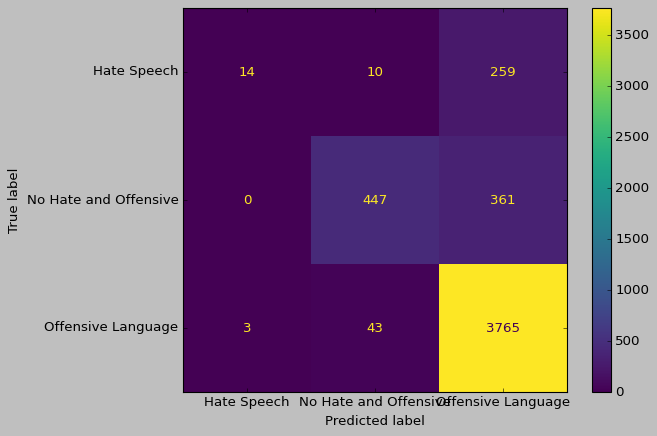

In [10]:
#printing confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix


print(confusion_matrix(Y_test, logreg_predict))
print("\n")
print(classification_report(Y_test, logreg_predict))

### Graphical representation of confusion matrix
from matplotlib.pyplot import style
from sklearn.metrics import ConfusionMatrixDisplay
style.use('classic')
cm = confusion_matrix(Y_test, logreg_predict, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot()

### For performing hyperparameter tuning

In [11]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
### Grid Search Training
param_grid = {'C':[100, 10, 1.0, 0.1, 0.01], 'solver' :['newton-cg', 'lbfgs','liblinear']}
grid = GridSearchCV(LogisticRegression(), param_grid, cv = 5)
grid.fit(X_train, Y_train)
print("Best Cross validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best Cross validation score: 0.89
Best parameters:  {'C': 100, 'solver': 'lbfgs'}


In [12]:
### Testing the model after hyperparameter tuning
log_grid_pred = grid.predict(X_test)

log_grid_acc = accuracy_score(log_grid_pred, Y_test)
print("Test accuracy: {:.2f}%".format(log_grid_acc*100)) #printing model accuracy after applying hyperparamenter tuning

Test accuracy: 89.21%


[[  26   19  238]
 [   1  639  168]
 [  18   85 3708]]


                       precision    recall  f1-score   support

          Hate Speech       0.58      0.09      0.16       283
No Hate and Offensive       0.86      0.79      0.82       808
   Offensive Language       0.90      0.97      0.94      3811

             accuracy                           0.89      4902
            macro avg       0.78      0.62      0.64      4902
         weighted avg       0.88      0.89      0.87      4902



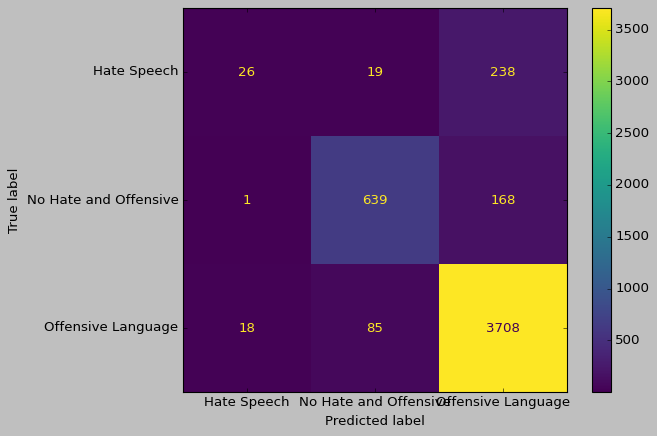

In [13]:
print(confusion_matrix(Y_test, log_grid_pred))
print("\n")
print(classification_report(Y_test, log_grid_pred))

#for visualizing confusion matrix
style.use('classic')
cm = confusion_matrix(Y_test, log_grid_pred, labels=grid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid.classes_)
disp.plot()